
# Multi-objective Bayesian Optimization


TNK function
$n=2$ variables:
$x_i \in [0, \pi], i=1,2$

Objectives:
- $f_i(x) = x_i$

Constraints:
- $g_1(x) = -x_1^2 -x_2^2 + 1 + 0.1 \cos\left(16 \arctan \frac{x_1}{x_2}\right) \le 0$
- $g_2(x) = (x_1 - 1/2)^2 + (x_2-1/2)^2 \le 0.5$

In [1]:
%reset -f
import numpy as np

import torch
from xopt import XoptBase, Evaluator
from xopt.generators.bayesian import MOBOGenerator
from xopt.resources.test_functions.tnk import evaluate_TNK, tnk_vocs

import pandas as pd

evaluator = Evaluator(evaluate_TNK)
print(tnk_vocs.dict())

{'variables': {'x1': [0.0, 3.14159], 'x2': [0.0, 3.14159]}, 'constraints': {'c1': ['GREATER_THAN', 0.0], 'c2': ['LESS_THAN', 0.5]}, 'objectives': {'y1': 'MINIMIZE', 'y2': 'MINIMIZE'}, 'constants': {'a': 'dummy_constant'}, 'linked_variables': None}


In [2]:
generator = MOBOGenerator(tnk_vocs)
generator.options.n_initial=2,
generator.options.optim.num_restarts = 1
generator.options.optim.raw_samples = 20

generator.options.acq.proximal_lengthscales=[1.0,1.0]
X = XoptBase(generator=generator, evaluator=evaluator, vocs=tnk_vocs)
X.step()
#X.step()
for i in range(30):
    print(i)
    X.step()

X.update_data()


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29


In [3]:
X.generator.data

,x1,x2,a,y1,y2,c1,c2,some_array,xopt_error,xopt_error_str
0,1.025068,2.873196,dummy_constant,1.025068,2.873196,8.236356,5.907755,"[1, 2, 3]",False,
1,1.231064,0.388421,dummy_constant,1.231064,0.388421,0.648713,0.546905,"[1, 2, 3]",False,
2,1.582373,0.470408,dummy_constant,1.582373,0.470408,1.734079,1.172406,"[1, 2, 3]",False,
3,1.082281,0.506748,dummy_constant,1.082281,0.506748,0.353160,0.339096,"[1, 2, 3]",False,
4,0.934921,0.487499,dummy_constant,0.934921,0.487499,0.095442,0.189313,"[1, 2, 3]",False,
5,0.779291,0.347372,dummy_constant,0.779291,0.347372,-0.363105,0.101299,"[1, 2, 3]",False,
6,0.560903,0.324857,dummy_constant,0.560903,0.324857,-0.527981,0.034384,"[1, 2, 3]",False,
7,0.299792,0.334540,dummy_constant,0.299792,0.334540,-0.862263,0.067460,"[1, 2, 3]",False,
8,0.321330,0.598937,dummy_constant,0.321330,0.598937,-0.535547,0.041711,"[1, 2, 3]",False,
9,0.413372,0.753405,dummy_constant,0.413372,0.753405,-0.244075,0.071718,"[1, 2, 3]",False,


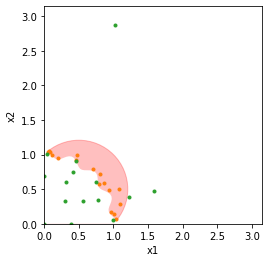

In [4]:
import matplotlib.pyplot as plt

fig,ax = plt.subplots()

theta = np.linspace(0,np.pi/2)
r = np.sqrt(1 + 0.1*np.cos(16*theta))
x_1 = r*np.sin(theta)
x_2_lower = r*np.cos(theta)
x_2_upper = (0.5 - (x_1 - 0.5)**2)**0.5 + 0.5

z = np.zeros_like(x_1)

#ax2.plot(x_1, x_2_lower,'r')
ax.fill_between(x_1, z, x_2_lower, fc='white')
circle = plt.Circle((0.5, 0.5), 0.5**0.5,
                    color='r', alpha=0.25, zorder=0,
                    label='Valid Region')
ax.add_patch(circle)
history = pd.concat([X.data, tnk_vocs.feasibility_data(X.data)], axis=1, ignore_index=False)



ax.plot(*history[["x1","x2"]][history["feasible"]].to_numpy().T,'.C1')
ax.plot(*history[["x1","x2"]][~history["feasible"]].to_numpy().T,'.C2')

ax.set_xlim(0, 3.14)
ax.set_ylim(0, 3.14)
ax.set_xlabel('x1')
ax.set_ylabel('x2')
ax.set_aspect('equal')

<AxesSubplot:xlabel='x1'>

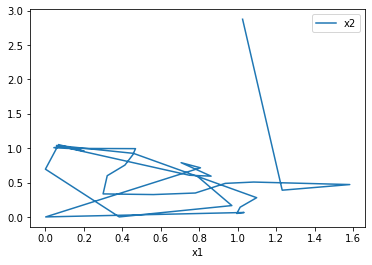

In [5]:
history.plot("x1","x2")

C:\ProgramData\Miniconda3\envs\xopt\lib\site-packages\torch\functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ..\aten\src\ATen\native\TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


[[0.94357394 0.18321375]]


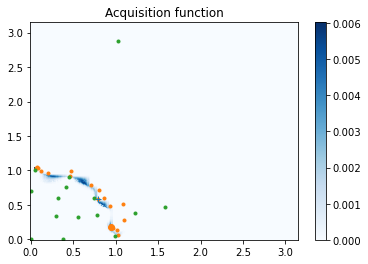

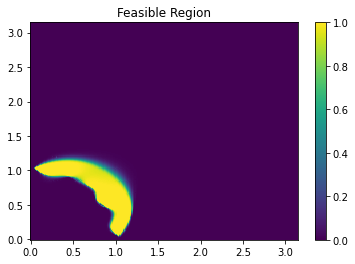

In [6]:
# plot the acquisition function
from xopt.generators.bayesian.utils import feasibility
bounds = generator.vocs.bounds
generator.train_model()
model = generator.model

# create mesh
n = 200
x = torch.linspace(*bounds.T[0],n)
y = torch.linspace(*bounds.T[1],n)
xx,yy = torch.meshgrid(x,y)
pts = torch.hstack([ele.reshape(-1,1) for ele in (xx,yy)]).double()

acq_func = generator.get_acquisition(model)
with torch.no_grad():
    acq_pts = pts.unsqueeze(1)
    acq = acq_func(acq_pts)

    fig, ax = plt.subplots()
    c = ax.pcolor(xx,yy,acq.reshape(n,n), cmap='Blues')
    fig.colorbar(c)
    ax.set_title('Acquisition function')

    ax.plot(*history[["x1","x2"]][history["feasible"]].to_numpy().T,'.C1')
    ax.plot(*history[["x1","x2"]][~history["feasible"]].to_numpy().T,'.C2')

    ax.plot(*history[["x1","x2"]].to_numpy()[-1].T,'+')

    feas = feasibility(
        pts.unsqueeze(1),
        model,
        generator.sampler,
        tnk_vocs
    ).flatten()

    fig2, ax2 = plt.subplots()
    c = ax2.pcolor(xx,yy,feas.reshape(n,n))
    fig2.colorbar(c)
    ax2.set_title('Feasible Region')

candidate = generator.generate(1)
print(candidate[["x1","x2"]].to_numpy())
ax.plot(*candidate[["x1","x2"]].to_numpy()[0],'o')

In [7]:
candidate = generator.generate(1)